In [1]:
from imutils import paths
import matplotlib.pyplot as plt
import argparse
import os
import tensorflow as tf
from tensorflow import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import skimage
from skimage.transform import resize
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
tf.__version__

'2.3.0'

In [2]:
dataset = "C:/Users/Tymon/Documents/treino/covid/Data/"

In [3]:
iPaths = list(paths.list_images(dataset))  # lista de caminhos das imagens
data = [] # array com as imagens
labels = [] # array com os rótulos das imagens
for iPath in iPaths:
    label = iPath.split(os.path.sep)[-2]  # captura o rótulo da imagem por meio do caminho
    image = cv2.imread(iPath) # lê a imagens
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # ajusta as cores das imagens para RGB
    image = cv2.resize(image, (224, 224)) # ajusta o tamanho da imagem para 224x224 px
    data.append(image) # Guarda imagem no array
    labels.append(label) # Guarda rótulo no array
data = np.array(data) / 255.0 # Converte array de imagens para numpy e Normaliza a imagens
labels = np.array(labels) # Converte array de rótulos para numpy

LB = LabelBinarizer()  # Inicializa o binarizador de rótulos
labels = LB.fit_transform(labels) # tranforma os rótulos em 1s e 0s
labels = to_categorical(labels); # tranforma os dados em categóricos
labels[:5] #imprime os 5 primeiros rótulos

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [4]:
data.shape

(200, 224, 224, 3)

In [5]:
labels.shape

(200, 2)

Raios-x de tórax normal Vs Raio-x de tórax com Covid-19 


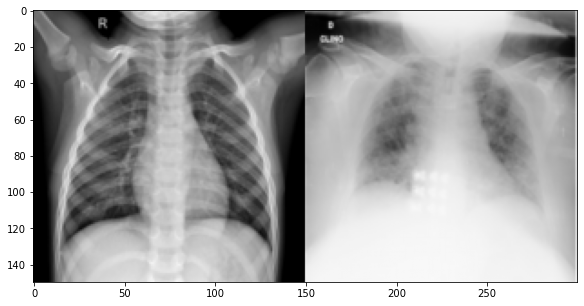

Raios-x de tórax normal Vs Raio-x de tórax com Covid-19 


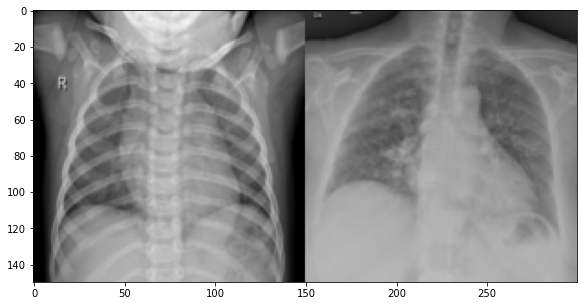

Raios-x de tórax normal Vs Raio-x de tórax com Covid-19 


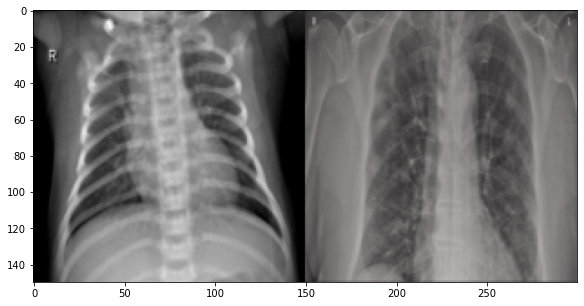

Raios-x de tórax normal Vs Raio-x de tórax com Covid-19 


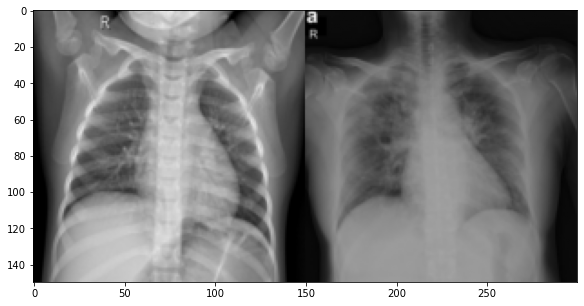

Raios-x de tórax normal Vs Raio-x de tórax com Covid-19 


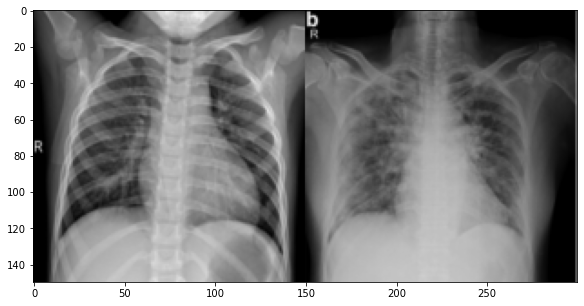

In [6]:
Cimages = os.listdir(dataset+"Covid")
Nimages = os.listdir(dataset+"Normal")
def plotter(i):
    normal = cv2.imread(dataset+"Normal//"+Nimages[i])
    normal = skimage.transform.resize(normal, (150, 150, 3))
    coronavirus = cv2.imread(dataset+"Covid//"+Cimages[i])
    coronavirus = skimage.transform.resize(coronavirus, (150, 150, 3) , mode = 'reflect')
    pair = np.concatenate((normal, coronavirus), axis=1)
    print("Raios-x de tórax normal Vs Raio-x de tórax com Covid-19 ")
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
for i in range(0,5):
    plotter(i)

In [7]:
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)
trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest")

C:\Users\Tymon\anaconda3\envs\covid_raiox_gpu\lib\site-packages\matplotlib\text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


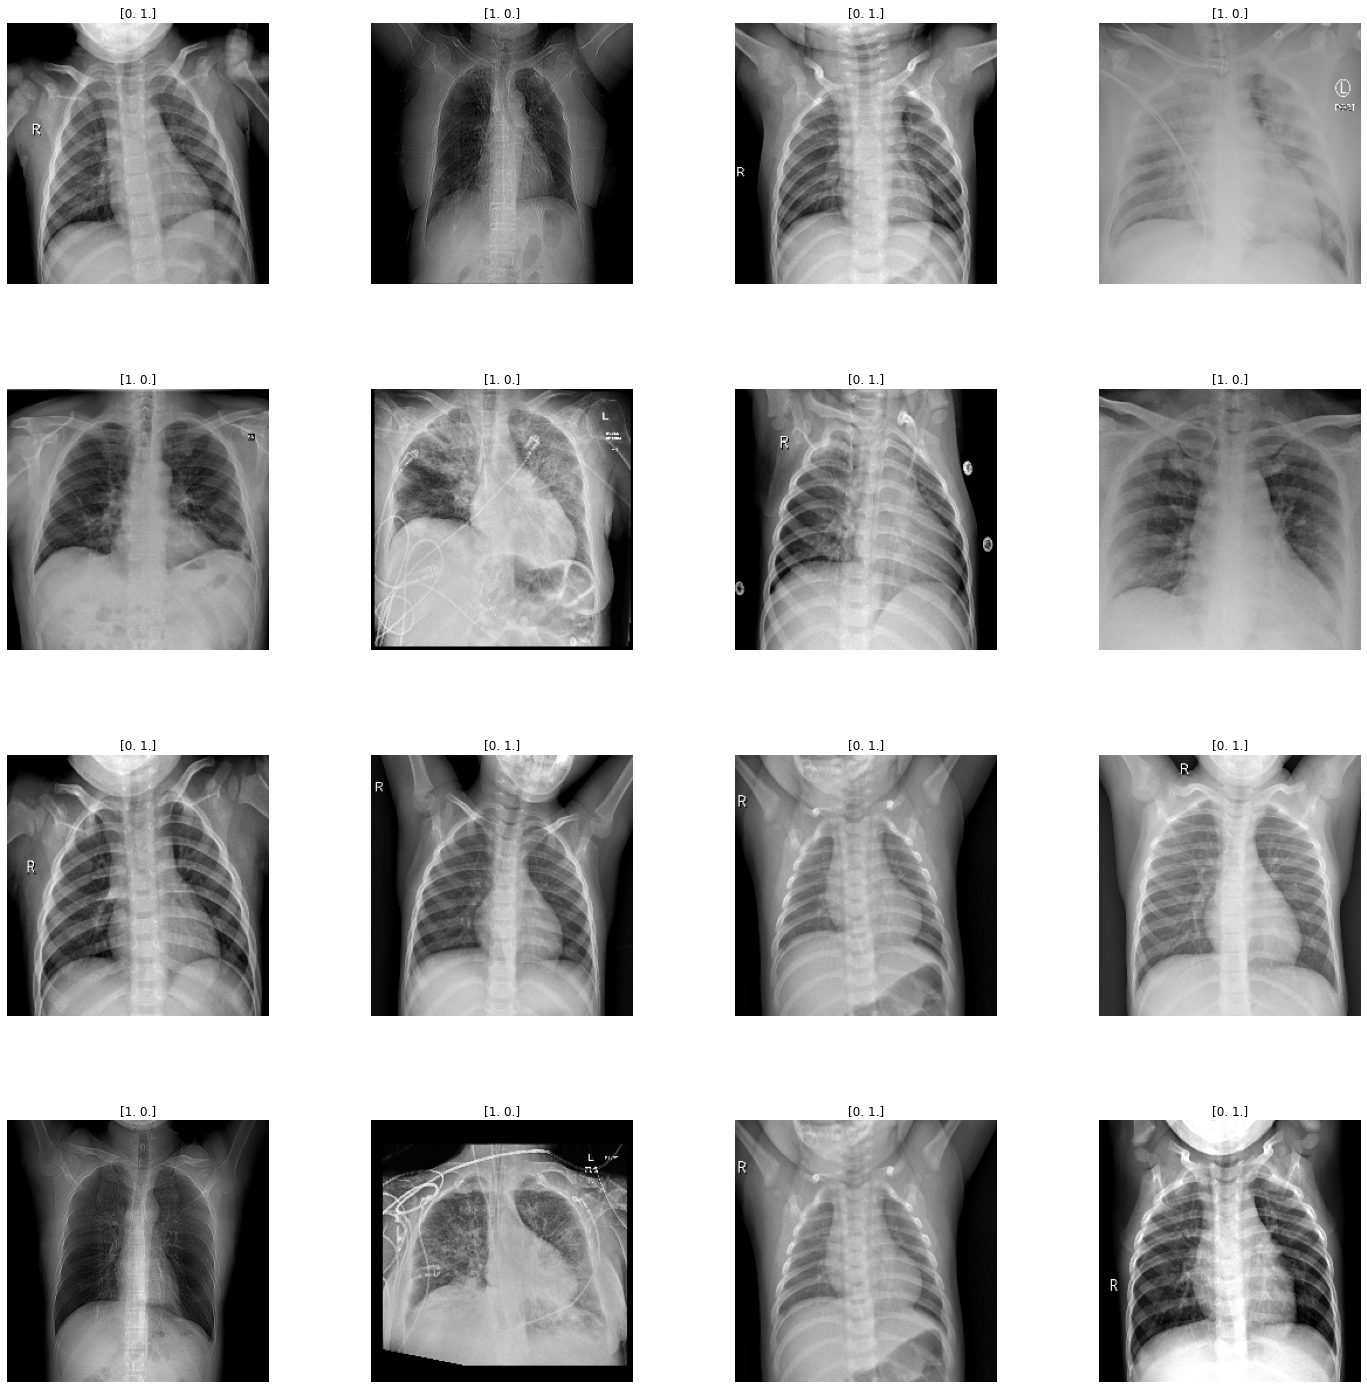

In [8]:
W_grid = 4 # largura da grade de imagens
L_grid = 4 # altura da grade de imagens
fig, axes = plt.subplots(L_grid, W_grid, figsize = (25, 25)) #tamanho de cada imagem
axes = axes.ravel()
n_training = len(X_train)
for i in np.arange(0, L_grid * W_grid):
    index = np.random.randint(0, n_training) # pega um número aleatório
    axes[i].imshow(X_train[index])
    axes[i].set_title(Y_train[index])
    axes[i].axis('off')
    
plt.subplots_adjust(hspace = 0.4)

In [9]:
bModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))  
hModel = bModel.output 
hModel = AveragePooling2D(pool_size=(4, 4))(hModel)
hModel = Flatten(name="flatten")(hModel)
hModel = Dense(64, activation="relu")(hModel)
hModel = Dropout(0.5)(hModel)
hModel = Dense(2, activation="softmax")(hModel)
model = Model(inputs=bModel.input, outputs=hModel)
for layer in bModel.layers:
    layer.trainable = False
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [10]:
INIT_LR = 1e-3
EPOCHS = 10
BS = 8
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

In [11]:
with tf.device('/GPU:0'):
    R = model.fit(
        trainAug.flow(X_train, Y_train, batch_size=BS),
        steps_per_epoch=len(X_train) // BS,
        validation_data=(X_test, Y_test),
        validation_steps=len(X_test) // BS,
        epochs=EPOCHS)

Epoch 1/10
20/20 [==============================] - 14s 688ms/step - loss: 0.7476 - accuracy: 0.5625 - val_loss: 0.5546 - val_accuracy: 0.6500
Epoch 2/10
20/20 [==============================] - 15s 732ms/step - loss: 0.4811 - accuracy: 0.7625 - val_loss: 0.4105 - val_accuracy: 1.0000
Epoch 3/10
20/20 [==============================] - 15s 765ms/step - loss: 0.4242 - accuracy: 0.8313 - val_loss: 0.3348 - val_accuracy: 0.9000
Epoch 4/10
20/20 [==============================] - 16s 798ms/step - loss: 0.2928 - accuracy: 0.9500 - val_loss: 0.2533 - val_accuracy: 0.9750
Epoch 5/10
20/20 [==============================] - 16s 820ms/step - loss: 0.2426 - accuracy: 0.9438 - val_loss: 0.2026 - val_accuracy: 1.0000
Epoch 6/10
20/20 [==============================] - 18s 880ms/step - loss: 0.1939 - accuracy: 0.9688 - val_loss: 0.1640 - val_accuracy: 1.0000
Epoch 7/10
20/20 [==============================] - 15s 769ms/step - loss: 0.1585 - accuracy: 0.9875 - val_loss: 0.1438 - val_accuracy: 1.0000

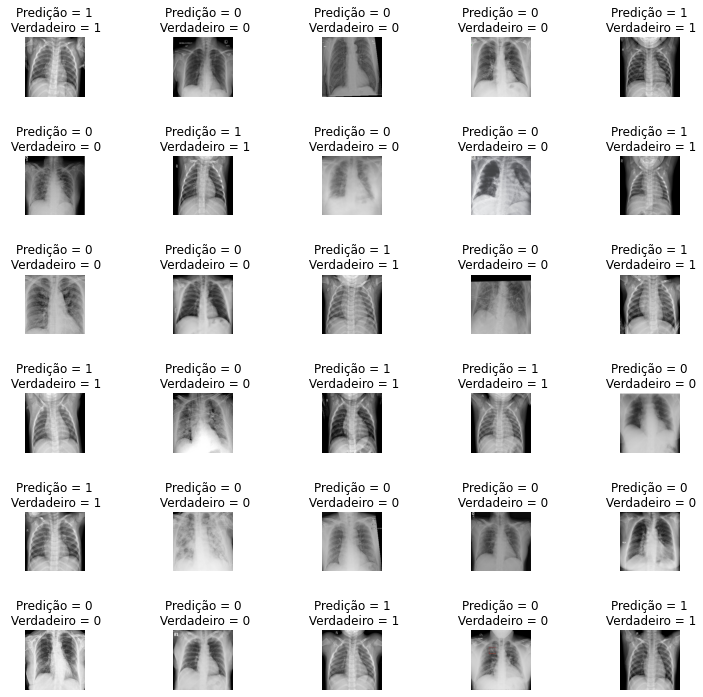

In [12]:
L = 6
W = 5
fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()
y_pred = model.predict(X_test, batch_size=BS)
for i in np.arange(0,L*W):
    axes[i].imshow(X_test[i])
    axes[i].set_title('Predição = {}\n Verdadeiro = {}'.format(y_pred.argmax(axis=1)[i], Y_test.argmax(axis=1)[i]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1, hspace=1)

In [13]:
y_pred = model.predict(X_test, batch_size=BS)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(Y_test.argmax(axis=1), y_pred,target_names=LB.classes_))

                                                   precision    recall  f1-score   support

 C:/Users/Tymon/Documents/treino/covid/Data/Covid       1.00      1.00      1.00        20
C:/Users/Tymon/Documents/treino/covid/Data/Normal       1.00      1.00      1.00        20

                                         accuracy                           1.00        40
                                        macro avg       1.00      1.00      1.00        40
                                     weighted avg       1.00      1.00      1.00        40



In [14]:
cm = confusion_matrix(Y_test.argmax(axis=1), y_pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print(cm)
print("acurácia: {:.4f}".format(acc))
print("sensibilidade: {:.4f}".format(sensitivity))
print("especificidade: {:.4f}".format(specificity))

[[20  0]
 [ 0 20]]
acurácia: 1.0000
sensibilidade: 1.0000
especificidade: 1.0000


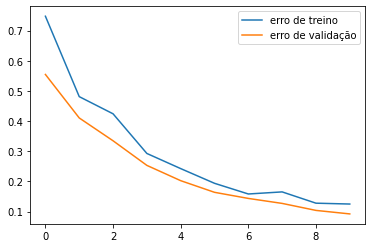

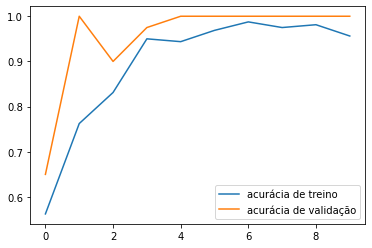

In [15]:
# Gráfico do erro
plt.plot(R.history['loss'], label='erro de treino')
plt.plot(R.history['val_loss'], label='erro de validação')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# Gráfico de acurácia
plt.plot(R.history['accuracy'], label='acurácia de treino')
plt.plot(R.history['val_accuracy'], label='acurácia de validação')
plt.legend()
plt.show()

In [16]:
model.save('Covid_model.h5')

Predição: COVID-19


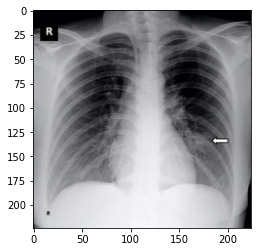

In [17]:
model = tf.keras.models.load_model('Covid_model.h5')
img = cv2.imread(dataset+'covid/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-000-fig1a.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # ajusta as cores das imagens para RGB
img = cv2.resize(img, (224, 224)) # ajusta o tamanho da imagem para 224x224 px
imgplot = plt.imshow(img)
x = np.array(img) / 255.0
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
New_pred = np.argmax(classes, axis=1)
if New_pred==[1]:
    print('Predição: Normal')
else:
    print('Predição: COVID-19')